# Data Dictionary


User knowledge is where a person who uses knowledge generated through research to make informed decisions about policies, programs and/or best practices. This dataset was part of the Ph.D. Thesis of Dr. Hamdi Tolga Kahraman from Turkey back in 2009. It is an unlabelled dataset containing 5 features as explained in the column descriptions. The data contains real information about the student's knowledge status about the subject of Electrical DC Machines. 

The user knowledge dataset has 6 columns and 258 isntances.

The database can be downloaded from this [link](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)

| Atrribute Position| Atrribute Name | Definition    | Data Type| Example | 
|---:|:-------------|:-----------|:-------------|:-----------|
| 1 | STG | The degree of study time for goal object materails       |  Quantitative (continuous) | 0.2,0.9,..|
| 2 | SCG | The degree of repetition number of user for goal object materails |  Quantitative (continuous) |  0.2,0.9,..|
| 3 | STR | The degree of study time of user for related objects with goal object |  Quantitative (continuous) |  0.2,0.9,..|
| 4 | LPR | The exam performance of user for related objects with goal object |  Quantitative (continuous) |  0.2,0.9,..|
| 5 | PEG | The exam performance of user for goal objects |  Quantitative (continuous) |  0.2,0.9,..|
| 6 | UNS | The knowledge level of user |  Quantitative (continuous) |  0.2,0.9,..|


The goal is to explore the pattern of the data, find clusters within data and make meaningful conclusions.

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from scipy.spatial import distance_matrix 
import time
import sklearn.metrics as metrics
from sklearn.cluster import MiniBatchKMeans, KMeans, AgglomerativeClustering, OPTICS, MeanShift, estimate_bandwidth, DBSCAN, AffinityPropagation ,SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances_argmin
import scipy.cluster.hierarchy as hcluster
from  scipy.cluster import hierarchy
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import matplotlib.cm as cm
import functions
import warnings
warnings.filterwarnings('ignore')

In [139]:
df = pd.read_csv("data/Data_User_Modeling_Dataset.csv")
print("data size : {} ".format(df.shape))

data size : (403, 7) 


In [142]:
df.head()

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,very_low
1,1,0.08,0.08,0.10,0.24,0.90,High
2,2,0.06,0.06,0.05,0.25,0.33,Low
3,3,0.10,0.10,0.15,0.65,0.30,Middle
4,4,0.08,0.08,0.08,0.98,0.24,Low


### Data Preprocessing


For this dataset, the Data Preprocessing steps include:

- Removal of valueless columns.
- Updating empty values with the mean of the respective column.
- Checking for outliers.
- Standardize the dataset by using min-max scaler.


In [144]:
len(df['Unnamed: 0'].unique())

403

We have total 403 instances, and Unnamed field has 403 unique instances, it means it is a unique identifer for each row and does not add any to out clustering process, sow e can remove this column

In [145]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [146]:
df.describe()

,STG,SCG,STR,LPR,PEG
count,403.000000,403.000000,403.000000,403.000000,403.000000
mean,0.353141,0.355940,0.457655,0.431342,0.456360
std,0.212018,0.215531,0.246684,0.257545,0.266775
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.265000,0.250000,0.250000
50%,0.300000,0.300000,0.440000,0.330000,0.400000
75%,0.480000,0.510000,0.680000,0.650000,0.660000
max,0.990000,0.900000,0.950000,0.990000,0.990000


Since the minimum and max value for each column is between 0 and 1, meaning our dataset is already normalized so we would not be needing normalization step again for pre-processign step, But we need to check for the outliers. The above statistical summary also shows that each attribute seems to have same type of data distribution.

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     403 non-null    float64
 1   SCG     403 non-null    float64
 2   STR     403 non-null    float64
 3   LPR     403 non-null    float64
 4   PEG     403 non-null    float64
 5    UNS    403 non-null    object 
dtypes: float64(5), object(1)
memory usage: 19.0+ KB


We also do not have any null values in our dataset, but we need to check for UNS column as it's data type is an object

In [148]:
df[' UNS'].unique()

array(['very_low', 'High', 'Low', 'Middle', 'Very Low'], dtype=object)

UNS field has total 5 categories in which two categories very_low and Very Low represents the same meaning of both of the attributes, so we need to replace the Very Low categorical value to very_low.


In [149]:
df[' UNS']= df[' UNS'].replace(['Very Low'],['very_low'])

Now let's look at the count of UNS for it's respective categories

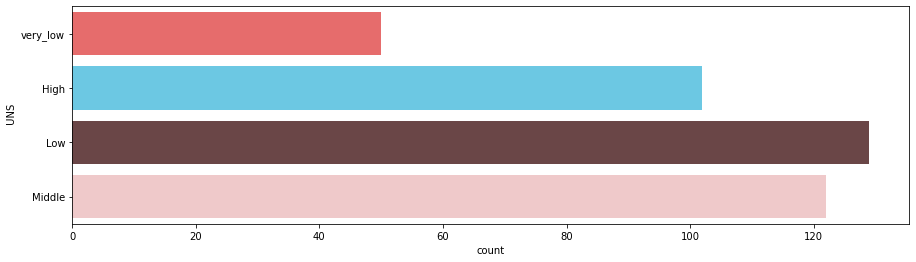

In [151]:
plt.figure(1 , figsize = (15 , 4))
color_palette = ["#FA5858", "#58D3F7", "#704041", "#f5c3c4"]
sns.countplot(y = ' UNS' , data = df, palette = color_palette)
plt.show()

From the above chart we scn observe that highest proportion we have in the data is of the Low class and the Middle class. From this observation we can observe that the users that are involved in research seems to have a low-to-medium level of knowledge.

Here we are encoding the UNS field to it's numerical values.

In [154]:
label_encoder = LabelEncoder()
df[' UNS']= label_encoder.fit_transform(df[' UNS'])  
df[' UNS'].unique()

array([3, 0, 1, 2])

In [155]:
numerical_df = df.select_dtypes(include=['float64'])

#####  plot distribution of numerical attributes

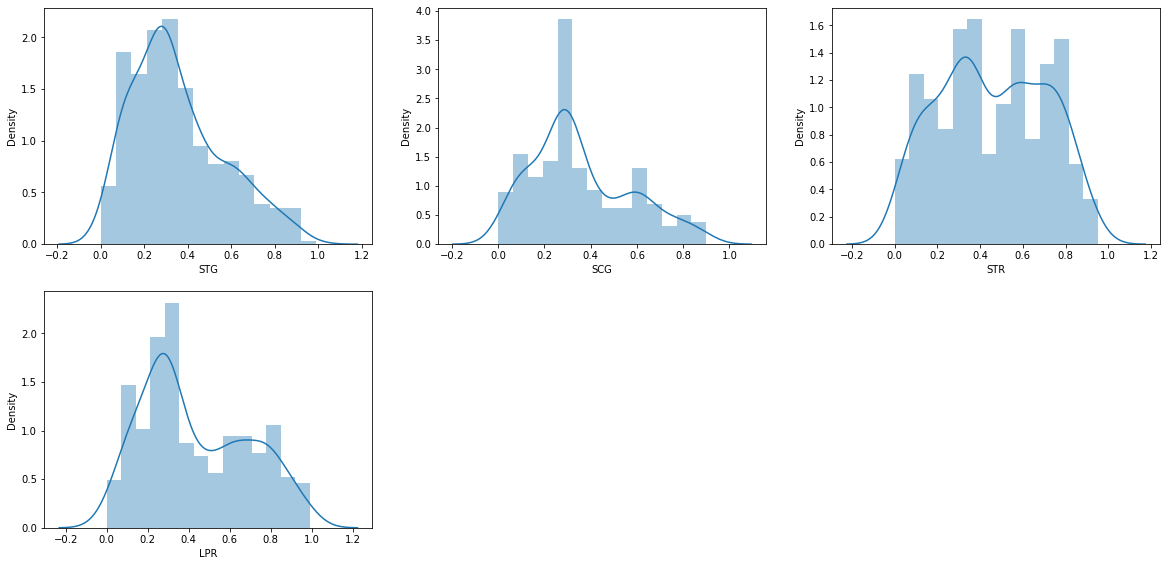

In [157]:
numerical_attributes_plot_distrbution(numerical_df)

The plot above shows the distribution in each column. From the visulazation we do not seems to find any outlier in the dataset. 

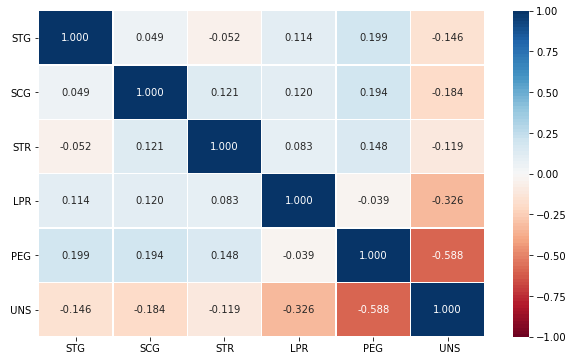

In [159]:
plot_corr_matrix(df)

from the above result, we are able to observe that the none of the data column are highly correlated with each other as no attribute has correlation value > 0.2

#### Checking for Outliers

Here we are checking for all the outliers, by getting each variable upper and lower extream values and removing which does not lie in IQR Range

In [161]:
cleaned_data = process_outliers(numerical_df)
len(cleaned_data)

403

the data instances are same, meaning we do not have outlier in the dataset.

In [162]:
cleaned_dsata.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


In [192]:
X = df[['STG' , 'PEG']].iloc[: , :].values
y = df[[' UNS']]

In [193]:
y

,UNS
0,3
1,0
2,1
3,2
4,1
...,...
398,0
399,0
400,1
401,2


# Cluster Analysis

This section is divided into two parts. In the first part we will be doing a comparative analysis of Gaussian mixture model with it's paramter's best value using Grid Search Technique. And In the second part we will be performing a comparartive analysis of <b>Gaussian mixture model </b> with other models that include <b>Bayesian Gaussian Mixture, Mini-Batch K-means, OPTICS, DBSCAN, Agglomerative, Spectral Clustering and Affinity Propagation </b> with their respective hyper-paramter tuning using Grid Search Technique. No of best paramters would be chosen on the basis of maximum silhoutte score.

We will be further evaulating our cluster performance using following measures: 
    
###### Intrinsic Measures that does not require ground truth labels (y)
- silhouette_score measures the between-cluster distance against within-cluster distance. A higher score signifies better-defined clusters. It is good for well define cluster as well as measure the interpretability of clusters.
- davies_bouldin_score measures the size of clusters against the average distance between clusters. A lower score signifies better-defined clusters. A lower score means that the cluster is relatively small compared to the distance to another cluster, hence well-defined.
- calinski_harabasz_score measures the between-cluster dispersion against within-cluster dispersion. A higher score signifies better-defined clusters. A higher ratio signifies the cluster is far away from its other clusters and that the cluster is more well-defined
    
    
###### Extrinsic Measures that requires ground truth labels (y)
- fowlkes_mallows_score measure the correctness of the cluster assignments using pairwise precision and recall. A higher score signifies higher similarity.
- adjusted_rand_score measures the similarity between the cluster assignments by making pair-wise comparisons. A higher score signifies higher similarity.
- adjusted_mutual_info_score measures the agreement between the cluster assignments. A higher score signifies higher similarity.
- homogeneity_score measures the precision of cluster, meaning each cluster contains only members of a single class. 
- completeness_score measures the recall of cluster, meaning all members of a given class are assigned to the same cluster.
- v_measure_score measures the correctness of the cluster assignments and used to measure interpretability of clusters. A higher score signifies higher similarity.


## Part 1: Comparative Analysis of Gaussian mixture model with it's hyper-parameters

A Gaussian mixture model (GMM) assists to find a mixture of multi-dimensional Gaussian probability distributions that best models dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

Here, first we would only be applying Gaussian Mixture Model with 2 components, then with addition of each hyperparamter using Grid Search to get the best possible attribute combination, we would be doing a comparative analysis as how each parameter is effecting the result of clustering. We would be doing comparative analysis using

- GMM with n_components = 2
- GMM with n_components and covariance_type using Grid Search 
- GMM with n_components and max_iter using Grid Search 
- GMM with n_components and init_params using Grid Search 
- GMM with n_components and n_init using Grid Search 


#### GMM with n_components = 2

n_components refers to the number of mixture components.

First we would just be using fixed no of n_components with all the default parameters to see how the clusers are formed for our dataset.

In [197]:
gmm1 = GaussianMixture(n_components = 2)

gmm1.fit(X)
gmm1_labels = gmm1.fit_predict(X)
gmm1_dataset = pd.DataFrame(X.copy())
gmm1_dataset.loc[:,'Cluster'] = gmm1_labels
gmm1_dataset.Cluster.value_counts().to_frame()

,Cluster
0,203
1,200


In [198]:
gmm_df1 = pd.DataFrame(estimator_evaluation2(gmm1, 'GaussianMixture ', X , y), index=["GaussianMixture with n_components only"])
gmm_df1

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with n_components only,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


#### GMM with n_components and covariance_type using Grid Search

covariance_type parameter controls the degrees of freedom in the shape of cluster. That is what allows for adjusting for different shapes of the clusters and that is why it is an essential to set this carefully for the given problem. 


- full(default): it referes to have each component has its own general covariance matrix, which allows each cluster to be modeled as an ellipse with it's arbitrary orientation.
- tied: it referes to have all components share the same general covariance matrix.
- diag: it referes to have each component has its own diagonal covariance matrix, which means that the size of the cluster with each dimension can be set independently.
- spherical: it referes to have each component has its own single variance, which is a simpler and faster model that constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means.

We would be using the best covariance_type for our problem analysis using Grid Search Hyper-parameter technique.

In [199]:
gmm_grid = {
        "covariance_type": ['full', 'tied', 'diag', 'spherical'],
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model2 = GaussianMixture()
gmm_params2 = GridSearchCV(gmm_model2,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params2.best_params_)
gmm2 = GaussianMixture(covariance_type = gmm_params2.best_params_['covariance_type'],
                      n_components = gmm_params2.best_params_['n_components'])

gmm2.fit(X)
gmm2_labels = gmm2.fit_predict(X)
gmm2_dataset = pd.DataFrame(X.copy())
gmm2_dataset.loc[:,'Cluster'] = gmm2_labels
gmm2_dataset.Cluster.value_counts().to_frame()

{'covariance_type': 'diag', 'n_components': 2}


,Cluster
1,203
0,200


In [200]:
gmm_df2 = pd.DataFrame(estimator_evaluation2(gmm2, 'GaussianMixture ', X , y), index=["GaussianMixture with covariance_type"])
gmm_df2

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with covariance_type,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


#### GMM with n_components and max_iter using Grid Search 

max_iter refers to the number of EM iterations to perform.

As Gaussian Mixture models takes quite much time to run as compare to K-Means model because GMM takes long time to converge.
That is why we need to consider the amount of data and the features that needs to be given to GMM. When experimenting with the Bayesian Gaussian Mixture class, it often gives an errors of convergence that couldn’t be reached, in that case we need to increase the max_iter parameter.

We would be using the best max_iter for our problem analysis using Grid Search Hyper-paramter technique.

In [201]:
gmm_grid = {
        "max_iter": [50, 100, 150, 200, 250, 300],
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model3 = GaussianMixture()
gmm_params3 = GridSearchCV(gmm_model3,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params3.best_params_)
gmm3 = GaussianMixture(max_iter = gmm_params3.best_params_['max_iter'],
                      n_components = gmm_params3.best_params_['n_components'])

gmm3.fit(X)
gmm3_labels = gmm3.fit_predict(X)
gmm3_dataset = pd.DataFrame(X.copy())
gmm3_dataset.loc[:,'Cluster'] = gmm3_labels
gmm3_dataset.Cluster.value_counts().to_frame()

{'max_iter': 50, 'n_components': 2}


,Cluster
0,203
1,200


In [202]:
gmm_df3 = pd.DataFrame(estimator_evaluation2(gmm3, 'GaussianMixture ', X , y), index=["GaussianMixture with max_iter"])
gmm_df3

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with max_iter,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


#### GMM with n_components and init_params using Grid Search 

init_params refers to Initialization methods that helps to generate the initial centers for the model components. The innitial method for GMM are:

- k-means (default) :This refers to k-means clustering algorithm and can be computationally expensive compared to other initialization methods.

- k-means++ : This initialization method of k-means clustering picks the first center at random from the data, then the centers will be chosen from a weighted distribution of the data that favours points that are further away from the existing centers.

- random_from_data : This picks random data points from the input data as the initial centers, and it's fastest method of initialization but can result in producing non-convergent results if the selected points are way too close to each other.

- random : This chooses center randomly but away from the mean of all data, but as simple as it is, it can lead to the model taking longer to converge.

We would be using the best init_params for our problem analysis using Grid Search Hyper-paramter technique

In [203]:
gmm_grid = {
        "init_params": ['kmeans', 'k-means++', 'random', 'random_from_data'],
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model4 = GaussianMixture()
gmm_params4 = GridSearchCV(gmm_model4,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params4.best_params_)
gmm4 = GaussianMixture(init_params = gmm_params4.best_params_['init_params'],
                      n_components = gmm_params4.best_params_['n_components'])

gmm4.fit(X)
gmm4_labels = gmm4.fit_predict(X)
gmm4_dataset = pd.DataFrame(X.copy())
gmm4_dataset.loc[:,'Cluster'] = gmm4_labels
gmm4_dataset.Cluster.value_counts().to_frame()

{'init_params': 'kmeans', 'n_components': 2}


,Cluster
0,203
1,200


In [204]:
gmm_df4 = pd.DataFrame(estimator_evaluation2(gmm4, 'GaussianMixture ', X , y), index=["GaussianMixture with init_params"])
gmm_df4

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with init_params,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


#### GMM with n_components and n_init using Grid Search 

n_init refers to the number of initializations to be performed in GMM.

We would be using the best n_init for our problem analysis using Grid Search Hyper-paramter technique

In [205]:
gmm_grid = {
        "n_init": range(1, 6),
        "n_components": range(2, 10)
       }
gmm_grid
gmm_model5 = GaussianMixture()
gmm_params5 = GridSearchCV(gmm_model5,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)
print(gmm_params5.best_params_)
gmm5 = GaussianMixture(n_init = gmm_params5.best_params_['n_init'],
                      n_components = gmm_params5.best_params_['n_components'])

gmm5.fit(X)
gmm5_labels = gmm5.fit_predict(X)
gmm5_dataset = pd.DataFrame(X.copy())
gmm5_dataset.loc[:,'Cluster'] = gmm5_labels
gmm5_dataset.Cluster.value_counts().to_frame()

{'n_components': 2, 'n_init': 2}


,Cluster
0,203
1,200


In [206]:
gmm_df5 = pd.DataFrame(estimator_evaluation2(gmm5, 'GaussianMixture ', X , y), index=["GaussianMixture with n_init"])
gmm_df5

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with n_init,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


In [207]:
gmm_result = gmm_df1.append([gmm_df2, gmm_df3,gmm_df4,gmm_df5])
gmm_result

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture with n_components only,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007
GaussianMixture with covariance_type,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007
GaussianMixture with max_iter,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007
GaussianMixture with init_params,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007
GaussianMixture with n_init,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


### Part 1 Performance Analysis:

From the above result set of all those 5 GMM model with it's different paramters, we can conclude that

Since all the scores for each model of GMM are same and there is no improvement with the addition and subtraction of parameter, GMM has been converged.

## Part 2: Comparative Analysis of Gaussian Mixture Model with Bayesian Gaussian Mixture, Mini-Batch K-means, OPTICS, DBSCAN, Agglomerative, Spectral Clustering and Affinity Propagation

### Gaussian Mixture Model

A Gaussian mixture model (GMM) assists to find a mixture of multi-dimensional Gaussian probability distributions that best models dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means.

In [208]:

gmm_grid = {
        "covariance_type": ['full', 'tied', 'diag', 'spherical'],
        "max_iter": [50, 100, 150, 200, 250, 300],
        "init_params": ['kmeans', 'k-means++', 'random', 'random_from_data'],
        "n_components": range(2, 15),
        "n_init": range(1, 6)
       }
gmm_grid

{'covariance_type': ['full', 'tied', 'diag', 'spherical'],
 'max_iter': [50, 100, 150, 200, 250, 300],
 'init_params': ['kmeans', 'k-means++', 'random', 'random_from_data'],
 'n_components': range(2, 15),
 'n_init': range(1, 6)}

In [209]:
gmm_model = GaussianMixture()
gmm_params = GridSearchCV(gmm_model,gmm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)

In [210]:
gmm_params.best_score_, gmm_params.best_params_

(0.6123466960367843,
 {'covariance_type': 'diag',
  'init_params': 'kmeans',
  'max_iter': 100,
  'n_components': 2,
  'n_init': 1})

In [211]:
gmm = GaussianMixture(covariance_type = gmm_params.best_params_['covariance_type'],
                      init_params = gmm_params.best_params_['init_params'],
                      n_components = gmm_params.best_params_['n_components'],
                      n_init = gmm_params.best_params_['n_init'],
                      max_iter = gmm_params.best_params_['max_iter'])

gmm.fit(X)
gmm_labels = gmm.fit_predict(X)

In [212]:
gmm_dataset = pd.DataFrame(X.copy())
gmm_dataset.loc[:,'Cluster'] = gmm_labels
gmm_dataset.Cluster.value_counts().to_frame()

,Cluster
1,203
0,200


In [213]:
gmm_df = pd.DataFrame(estimator_evaluation2(gmm, 'GaussianMixture ', X , y), index=["GaussianMixture"])
gmm_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
GaussianMixture,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007


In [214]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[gmm_labels])
fig.show()

### Bayesian Gaussian Mixture

Mixture models are useful for integrating multiple data generating processes into a single model. A gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of gaussian distributions with unknown parameters.

The Bayesian gaussian mixture is a variation of the Gaussian mixture. BGM is less sensitive to the number of parameters and it chooses effective components automatically.

In [215]:
bgm_grid = {
        "covariance_type": ['full', 'tied', 'diag', 'spherical'],
        "max_iter": [50, 100, 150, 200],
        "init_params": ['kmeans', 'k-means++', 'random', 'random_from_data'],
        "n_components": range(2, 10),
        "n_init": range(1, 6),
        "weight_concentration_prior_type" : ['dirichlet_process', 'dirichlet_distribution']
       }

#bgm_grid

In [216]:
bgm_model = BayesianGaussianMixture()
bgm_params = GridSearchCV(bgm_model,bgm_grid,scoring=silhouette_score3,cv= 10).fit(X, y)

In [217]:
bgm_params.best_score_, bgm_params.best_params_

(0.6247727291806158,
 {'covariance_type': 'spherical',
  'init_params': 'kmeans',
  'max_iter': 50,
  'n_components': 3,
  'n_init': 3,
  'weight_concentration_prior_type': 'dirichlet_process'})

In [218]:
bgm = BayesianGaussianMixture(covariance_type = bgm_params.best_params_['covariance_type'],
                      init_params = bgm_params.best_params_['init_params'],
                      n_components = bgm_params.best_params_['n_components'],
                      n_init = bgm_params.best_params_['n_init'],
                      max_iter = bgm_params.best_params_['max_iter'],
                      weight_concentration_prior_type = bgm_params.best_params_['weight_concentration_prior_type'])

bgm.fit(X)
bgm_labels = bgm.fit_predict(X)

In [219]:
bgm_dataset = pd.DataFrame(X.copy())
bgm_dataset.loc[:,'Cluster'] = bgm_labels
bgm_dataset.Cluster.value_counts().to_frame()

,Cluster
1,206
0,129
2,68


In [220]:
bgm_df = pd.DataFrame(estimator_evaluation2(bgm, 'BayesianGaussianMixture ', X , y), index=["BayesianGaussianMixture"])
bgm_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
BayesianGaussianMixture,0.467738,0.712547,389.653173,0.553664,0.311957,0.402539,0.347756,0.489131,0.406502


In [221]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[bgm_labels])
fig.show()

### Mini-Batch Kmean Clustering

Mini Batch K-means is a variation of K-means algorithm which introduces an idea of using small random batches of data of fixed size. For each iteration, a new random sample from the dataset is taken and used to modify the clusters and this process is repeated until convergence.

In [222]:
#mbk_model.get_params().keys()

In [223]:
k_mean_grid = {
        "batch_size": [50, 100, 150, 200],
        "max_iter": [50, 100, 150, 200],
        "init": ['k-means++', 'random'],
        "n_clusters": range(2, 10),
        "n_init": range(1, 6)
       }
k_mean_grid

{'batch_size': [50, 100, 150, 200],
 'max_iter': [50, 100, 150, 200],
 'init': ['k-means++', 'random'],
 'n_clusters': range(2, 10),
 'n_init': range(1, 6)}

In [224]:
mbk_model = MiniBatchKMeans()
mbk_params = GridSearchCV(mbk_model,k_mean_grid,scoring=silhouette_score,cv= 10).fit(X, y)

In [225]:
mbk_params.best_score_, mbk_params.best_params_

(0.6140698660869858,
 {'batch_size': 50,
  'init': 'k-means++',
  'max_iter': 50,
  'n_clusters': 2,
  'n_init': 2})

In [226]:
batch_size = 45
mbk = MiniBatchKMeans(init = mbk_params.best_params_['init'],
                      n_clusters = mbk_params.best_params_['n_clusters'],
                      batch_size = mbk_params.best_params_['batch_size'],
                      n_init = mbk_params.best_params_['n_init'],
                      max_iter = mbk_params.best_params_['max_iter'],
                      max_no_improvement = 10, verbose = 0)

mbk.fit(X)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)


In [227]:
mbk_dataset = pd.DataFrame(X.copy())
mbk_dataset.loc[:,'Cluster'] = mbk_means_labels

In [228]:
mbk_dataset.Cluster.value_counts().to_frame()

,Cluster
0,206
1,197


In [229]:
kmean_df = pd.DataFrame(estimator_evaluation(mbk, 'Mini-Batch K-means', X , y), index=["Mini-Batch Kmean"])
kmean_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Mini-Batch Kmean,0.462035,0.882063,411.029867,0.651976,0.418309,0.524302,0.399751,0.769069,0.526063


In [230]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[mbk_means_labels])
fig.show()

### Hierachical Clustering

Hierarchical clustering used to group objects in clusters based on their similar to each other. We would be using bottom-up clustering approach, where each data point is assigned to its own cluster, and then the similar clusters are merged iteratively until all of the data points are part of one big root cluster.


In [231]:
# Single linkage: 
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [232]:
agg_grid = {
        "affinity": ['euclidean', 'l1', 'l2', 'manhattan', 'precomputed'],
        "linkage" : ['ward', 'complete', 'average', 'single'],
        "n_clusters": range(2, 5)
       }
agg_grid

{'affinity': ['euclidean', 'l1', 'l2', 'manhattan', 'precomputed'],
 'linkage': ['ward', 'complete', 'average', 'single'],
 'n_clusters': range(2, 5)}

In [233]:
agg_model = AgglomerativeClustering()
agg_params = GridSearchCV(agg_model,agg_grid,scoring=silhouette_score,cv= 10).fit(X, y)

In [234]:
agg_params.best_score_, agg_params.best_params_

(0.6108486109573608,
 {'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 2})

In [235]:
agg_clustering_model = AgglomerativeClustering(n_clusters= agg_params.best_params_['n_clusters'], 
                                               linkage= agg_params.best_params_['linkage'], 
                                               affinity =  agg_params.best_params_['affinity'])
agg_clustering_model.fit(X)
agg_labels = agg_clustering_model.labels_

In [236]:
agg_dataset = pd.DataFrame(X.copy())
agg_dataset.loc[:,'Cluster'] = agg_labels
agg_dataset.Cluster.value_counts().to_frame()

,Cluster
0,202
1,201


In [237]:
X.shape[0]

403

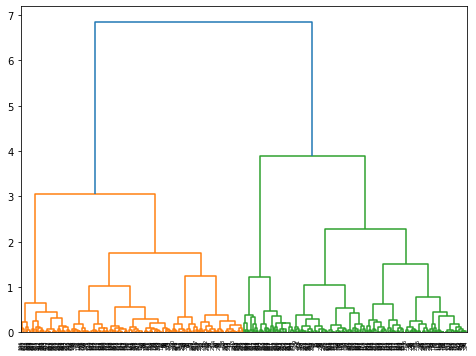

In [238]:
clusters = linkage(X, method=agg_params.best_params_['linkage'])

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)
plt.axhline(150, color='red', linestyle='--') 
plt.axhline(100, color='crimson')

In [239]:
agg_df = pd.DataFrame(estimator_evaluation(agg_clustering_model, 'Agglomerative Clustering ', X , y), index=["Agglomerative Clustering "])
agg_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Agglomerative Clustering,0.45704,0.885878,404.672291,0.657503,0.426582,0.523428,0.399138,0.767617,0.525192


### DBSCAN

DBSCAN is a non parametric clustering algorithm which groups the closed high density data points and those points that lie in the lower density areas are treated as outliers. It does this using Epsilon Parameter (Degree of closeness of points in the same cluster) and MinPts ( Minimum number of points inside the radius of circle )

In [240]:
dbscan_grid = {
        "min_samples": range(2,20,3),
        "metric": ['euclidean','dice' 'manhattan', 'cosine', 'precomputed'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "eps": np.arange(0.001,3,0.01)
       }
#dbscan_grid

In [242]:
dbscan_params.best_score_, dbscan_params.best_params_

(0.514228312921164,
 {'algorithm': 'auto',
  'eps': 0.11099999999999999,
  'metric': 'euclidean',
  'min_samples': 2})

In [243]:
dbscan_clustering = DBSCAN(eps= dbscan_params.best_params_['eps'], 
                    min_samples= dbscan_params.best_params_['min_samples'],
                    algorithm = dbscan_params.best_params_['algorithm'],
                    metric = dbscan_params.best_params_['metric']
                   ).fit(X)
DBSCAN_dataset = pd.DataFrame(X.copy())
DBSCAN_dataset.loc[:,'Cluster'] = dbscan_clustering.labels_ 

In [244]:
DBSCAN_dataset.Cluster.value_counts().to_frame()

,Cluster
0,402
-1,1


In [270]:
dbscan_df = pd.DataFrame(estimator_evaluation2(dbscan_clustering, 'DBSCAN', X ,y), index=["DBSCAN"])
dbscan_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
DBSCAN,0.352433,0.460664,4.002449,0.520202,0.00028,0.000151,0.002564,0.196871,0.005063


In [246]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[dbscan_clustering.labels_])
fig.show()

### Optics

OPTICS is also a density-based algorithm similar to DBSCAN, but as compare to DBSCAN, OPTICS can find meaningful clusters in data that varies in density. OPTICS does process by ordering the data points so that the closest points are neighbors in the ordering. 

In [247]:
optics_grid = {
        "min_samples" : range(7,20,3),
        "metric": ['euclidean','dice' 'manhattan', 'cosine', 'precomputed'],
        "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
        "eps": np.arange(0.01,1.1,0.01)
       }
#dbscan_grid

In [248]:
optics_model = OPTICS()
optics_params = GridSearchCV(optics_model,optics_grid,scoring=silhouette_score2,cv= 10).fit(X, y)

In [249]:
optics_params.best_score_, optics_params.best_params_

(0.472701926323285,
 {'algorithm': 'brute', 'eps': 0.01, 'metric': 'euclidean', 'min_samples': 10})

In [250]:
optics_clustering = OPTICS(min_samples = optics_params.best_params_['min_samples'],
                           algorithm = optics_params.best_params_['algorithm'],
                           metric = optics_params.best_params_['metric'],
                           eps = optics_params.best_params_['eps']
                          ).fit(X)
cluster = list(optics_clustering.labels_)
values, counts = np.unique(cluster, return_counts=True)      
optics_dataset = pd.DataFrame(X.copy())
optics_dataset.loc[:,'Cluster'] = optics_clustering.labels_


In [251]:
optics_dataset.Cluster.value_counts().to_frame()

,Cluster
-1,156
11,31
6,31
5,31
10,25
7,22
1,21
9,18
4,18
3,18


In [252]:

Optics_df = pd.DataFrame(estimator_evaluation(optics_clustering, 'Optics ', X , y), index=["Optics"])
Optics_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Optics,0.064336,1.640537,33.961702,0.290139,0.084145,0.29847,0.415201,0.257518,0.317879


In [253]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[optics_clustering.labels_])
fig.show()

### Spectral Clustering

Spectral CLustering is a graph based clustering technique which is used to identify communities of nodes in a graph based on the edges connecting the nodes. It uses an information from the eigenvalues of special matrices that are built from the graph/data set.

In [254]:
spectral_grid = {
        "eigen_solver" : ['arpack','amg'],
        "n_clusters" : range(2,10),
        "n_init" : range(2,6),
    
        "n_neighbors" : range(7,20,2),
        "affinity": ['nearest_neighbors','rbf' 'precomputed'],
        "assign_labels" : ['kmeans', 'discretize', 'cluster_qr'],
       }
#spectral_grid

In [255]:
spectral_model = SpectralClustering()
spectral_params = GridSearchCV(spectral_model,spectral_grid,scoring=silhouette_score2,cv= 10).fit(X, y)

In [256]:
spectral_params.best_score_, spectral_params.best_params_

(0.6108486109573608,
 {'affinity': 'nearest_neighbors',
  'assign_labels': 'kmeans',
  'eigen_solver': 'arpack',
  'n_clusters': 2,
  'n_init': 2,
  'n_neighbors': 13})

In [257]:
Spectral_clustering = SpectralClustering(affinity = spectral_params.best_params_['affinity'],
                           assign_labels = spectral_params.best_params_['assign_labels'],
                           eigen_solver = spectral_params.best_params_['eigen_solver'],
                           n_clusters = spectral_params.best_params_['n_clusters'],
                           n_init = spectral_params.best_params_['n_init'],
                           n_neighbors = spectral_params.best_params_['n_neighbors']
                          ).fit(X)
cluster = list(Spectral_clustering.labels_)
values, counts = np.unique(cluster, return_counts=True)      
Spectral_dataset = pd.DataFrame(X.copy())
Spectral_dataset.loc[:,'Cluster'] = Spectral_clustering.labels_


In [258]:
Spectral_dataset.Cluster.value_counts().to_frame()

,Cluster
0,204
1,199


In [259]:
Spectral_df = pd.DataFrame(estimator_evaluation(Spectral_clustering, 'Spectral ', X , y ), index=["SpectralClustering"])
Spectral_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
SpectralClustering,0.460687,0.882917,409.154861,0.656783,0.425483,0.530852,0.404745,0.778482,0.532588


In [260]:
# plot using tsne 
X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[Spectral_clustering.labels_])
fig.show()

### Affinity Propagation

In Affinity Propagation, each data point is considered as a node in a network that communicates with all other nodes to let each other know that how similar they are and starts forming clusters on the basis of nodes similarity in the data set. 

As messages are sent between nodes, sets of nodes (exemplars) are found and they represent the clusters.

In [261]:
aff_prop_grid = {
        "max_iter": [50, 100, 150, 200],
        "convergence_iter" : range(2,5),
        "damping" : np.arange(0.5,1.1,0.1),
        "affinity": ['euclidean']#,'precomputed']
       }
#aff_prop_grid

In [262]:
#aff_prop_grid
aff_prop_model = AffinityPropagation()
aff_prop_params = GridSearchCV(aff_prop_model,aff_prop_grid,scoring=silhouette_score2,cv= 10).fit(X, y)

In [263]:
aff_prop_params.best_score_, aff_prop_params.best_params_

(0.5573391618780417,
 {'affinity': 'euclidean',
  'convergence_iter': 2,
  'damping': 0.5,
  'max_iter': 50})

In [264]:
aff_prop_clustering = AffinityPropagation(affinity = aff_prop_params.best_params_['affinity'],
                           convergence_iter = aff_prop_params.best_params_['convergence_iter'],
                           damping = aff_prop_params.best_params_['damping'],
                           max_iter = aff_prop_params.best_params_['max_iter']
                          ).fit(X)
cluster = list(aff_prop_clustering.labels_)
values, counts = np.unique(cluster, return_counts=True)      
aff_prop_dataset = pd.DataFrame(X.copy())
aff_prop_dataset.loc[:,'Cluster'] = aff_prop_clustering.labels_


In [265]:
aff_prop_dataset.Cluster.value_counts().to_frame()

,Cluster
5,55
12,45
11,40
8,37
10,30
4,29
3,26
0,26
2,25
1,24


In [266]:

aff_prop_df = pd.DataFrame(estimator_evaluation(aff_prop_clustering, 'AffinityPropagation ', X , y), index=["AffinityPropagation"])
aff_prop_df

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
AffinityPropagation,0.457119,0.754832,553.329499,0.365079,0.208212,0.429078,0.649294,0.337406,0.444058


In [267]:

X_embedded  = TSNE(n_components=3, perplexity=10,random_state=24).fit_transform( X )
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmykb'])
fig = px.scatter_3d(x=X_embedded [:,0],y=X_embedded [:,1],z=X_embedded [:,2],color=colors[aff_prop_clustering.labels_])
fig.show()

In [271]:
result = kmean_df.append([gmm_df, bgm_df, agg_df, dbscan_df, Optics_df, Spectral_df, aff_prop_df])
result

,silhouette_score,davies_bouldin_score,calinski_harabasz_score,fowlkes_mallows_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_score,completeness_score,v_measure_score
Mini-Batch Kmean,0.462035,0.882063,411.029867,0.651976,0.418309,0.524302,0.399751,0.769069,0.526063
GaussianMixture,0.459953,0.883581,407.893785,0.659264,0.429165,0.534284,0.407353,0.783442,0.536007
BayesianGaussianMixture,0.467738,0.712547,389.653173,0.553664,0.311957,0.402539,0.347756,0.489131,0.406502
Agglomerative Clustering,0.457040,0.885878,404.672291,0.657503,0.426582,0.523428,0.399138,0.767617,0.525192
DBSCAN,0.352433,0.460664,4.002449,0.520202,0.000280,0.000151,0.002564,0.196871,0.005063
Optics,0.064336,1.640537,33.961702,0.290139,0.084145,0.298470,0.415201,0.257518,0.317879
SpectralClustering,0.460687,0.882917,409.154861,0.656783,0.425483,0.530852,0.404745,0.778482,0.532588
AffinityPropagation,0.457119,0.754832,553.329499,0.365079,0.208212,0.429078,0.649294,0.337406,0.444058


### Part 2 Performance Analysis:

From the above result set of all those 7 models, we are able to conclude that for this analysis, choosing best algorithm would mainly be on the basis of Extrinsic measures.

Silhoutte score, Calinski-Harabasz and Davies-Bouldin Index are not a good measure when comparing different types of clustering algorithms as these scores tend to be higher for density-based clustering algorithms, so it would not be fair to compare desnity based algorithm with other other types of clustering algorithms.

As for the individual analysis, Silhoutte score, Calinski-Harabasz and Davies-Bouldin Index for each model is comparatively same for all models except the silhouette_score for OPTICS and calinski_harabasz_score for DBSCAN, means OPTICS has failed to find the similarity in cluster and the clusters are not dense and well separated.

Other than the density based algorithm, silhouette_score, davies_bouldin_score and calinski_harabasz_score seems to be similar for each model.

fowlkes_mallows_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score,completeness_score and v_measure_score are higher for Mini-Batch Kmean, SpectralClustering,  and least for OPTICS and DBSCAN. And the recall of GaussianMixture Clustering is higher than all other model which is 78% , meaning only 78% of data points of a required class are elements of the same cluster, while the precision of 
AffinityPropagation is around 69% 

Hence using all the measures, GaussianMixture Clustering has given significantly higher score and performed better as compared to all other algorithms. Therefore, GaussianMixture Clustering is the best possible clustering algorithm for this dataset.